In [ ]:
from botorch.models import SingleTaskGP, ModelListGP
import torch
import time
import psutil
import os
from functools import wraps
from contextlib import redirect_stdout
import logging
import json


from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import SumMarginalLogLikelihood
from gpytorch.kernels import (
    ScaleKernel,
    MaternKernel,
    RBFKernel,
)


# --- Logging 配置 ---
logger = logging.getLogger("BO_Monitor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    ch = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    logger.addHandler(ch)


# ============================================================
# Decorator
# ============================================================

def monitor(runtime=True, memory=True, condition=False):
    def decorator(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):
            if not getattr(self, "debug", False):
                return func(self, *args, **kwargs)

            # 確保類別中有存儲紀錄的容器
            if not hasattr(self, 'performance_history'):
                self.performance_history = []

            # 紀錄開始資訊
            start_time = time.perf_counter()
            process = psutil.Process(os.getpid())
            
            # 執行函數
            result = func(self, *args, **kwargs)
            
            # 計算指標
            end_time = time.perf_counter()
            elapsed = end_time - start_time
            cpu_mem = process.memory_info().rss / 1024**2
            
            entry = {
                "iteration": getattr(self, "current_iter", "N/A"), # 追蹤當前疊代次數
                "function": func.__name__,
                "runtime_sec": round(elapsed, 4),
                "cpu_memory_mb": round(cpu_mem, 2),
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
            }

            if torch.cuda.is_available():
                entry["gpu_alloc_mb"] = round(torch.cuda.memory_allocated() / 1024**2, 2)

            # 如果需要紀錄條件數 (僅針對 fit 後的模型)
            if condition and getattr(self, "model", None) is not None:
                cond_list = []
                for i, m in enumerate(self.model.models):
                    with torch.no_grad():
                        K = m.covar_module(m.train_inputs[0]).evaluate()
                        eigvals = torch.linalg.eigvalsh(K)
                        cond = (eigvals.max() / eigvals.min()).item()
                        cond_list.append(cond)
                entry["condition_numbers"] = cond_list

            # 儲存到物件歷史紀錄
            self.performance_history.append(entry)
            
            # 同時印出日誌供參考
            logger.info(f"Finished {func.__name__} - {entry}")
            
            return result
        return wrapper
    return decorator




class BaselineGPEmulator:
    """
    Baseline Multi-Objective GP Emulator
    =====================================

    This class implements a multi-objective Gaussian Process (GP)
    surrogate model using independent SingleTaskGP models.

    Mathematical Form:

        y_k(z) = m_k(z) + g_k(z)

        m_k(z) : constant mean (default in SingleTaskGP)
        g_k(z) ~ GP(0, K_{θ_k})

    Each objective is modeled with an independent GP.

    Example:
        >>> import torch
        >>> from baseline_gp_emulator import BaselineGPEmulator
        >>>
        >>> # Generate training data
        >>> train_X = torch.rand(20, 3, dtype=torch.double)
        >>> train_Y = torch.rand(20, 2, dtype=torch.double)
        >>>
        >>> # Create emulator
        >>>
        >>> # method1 : RBF is defult
        >>> emulator = BaselineGPEmulator()  #defult = RBF
        >>>
        >>> # method2 : matern
        >>> emulator = BaselineGPEmulator(
        ...     kernel="matern"
        ... )
        >>>
        >>> # Fit model
        >>> model = emulator.fit(train_X, train_Y)
        >>>
        >>> # Make predictions
        >>> test_X = torch.rand(5, 3, dtype=torch.double)
        >>> mean, var = emulator.predict(test_X)
        >>>
        >>> mean.shape
        torch.Size([5, 2])
        >>> var.shape
        torch.Size([5, 2])
    """

    def __init__(
        self,
        device  = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        dtype   = torch.double,
        kernel    = "rbf",      # "rbf" or "matern"
        use_ard   = False,       # Whether to use Automatic Relevance Determination
        matern_nu = 2.5,         # Smoothness parameter for Matern kernel
        debug=False,   # Debug switch
        
    
    ):
        self.device = device
        self.dtype = dtype
        self.model = None
        self.mll = None

        self.kernel = kernel
        self.use_ard = use_ard
        self.matern_nu = matern_nu
        self.debug = debug
        self.performance_history = []
        self.current_iter = 0


    def _build_kernel(self, input_dim):

        """
        Construct covariance kernel based on configuration.

        If ARD is enabled, each input dimension has its own
        independent lengthscale parameter.
        """


        ard_dims = input_dim if self.use_ard else None

        if self.kernel == "matern":
            base_kernel = MaternKernel(
                nu=self.matern_nu,
                ard_num_dims=ard_dims,
            )
        else:  # default: RBF
            base_kernel = RBFKernel(
                ard_num_dims=ard_dims,
            )

        # ScaleKernel allows the model to learn an output scale parameter
        return ScaleKernel(base_kernel)


    @monitor(runtime=True, memory=True, condition=True)
    def fit(self, train_x: torch.Tensor, train_obj: torch.Tensor):
        """
        Fit the multi-objective GP surrogate model.

        Parameters
        ----------
        train_x : torch.Tensor
            Training inputs of shape (N, d)

        train_obj : torch.Tensor
            Training objectives of shape (N, k)

        Returns
        -------
        ModelListGP
            A ModelListGP containing independent SingleTaskGP models
            for each objective.
        """

        # If single objective (N,), convert to (N, 1)
        if train_obj.ndim == 1:
            train_obj = train_obj.unsqueeze(-1)

        input_dim = train_x.shape[-1]
        num_objectives = train_obj.shape[-1]

        models = []
        
        # Build one independent GP per objective
        for i in range(num_objectives):
            covar_module = self._build_kernel(input_dim)

            train_y = train_obj[..., i:i + 1]  # (N, 1)

            gp = SingleTaskGP(
                train_X=train_x,
                train_Y=train_y,
                outcome_transform=Standardize(m=1),
                covar_module=covar_module,
            )
            models.append(gp)

        # Combine independent GPs into ModelListGP
        self.model = ModelListGP(*models)

        # Define marginal log likelihood for multi-model case
        self.mll = SumMarginalLogLikelihood(
            self.model.likelihood, self.model
        )
        with open(os.devnull, 'w') as f:
            with redirect_stdout(f):
                fit_gpytorch_mll(self.mll)


        # Maximize marginal log likelihood
        fit_gpytorch_mll(self.mll)

        return self.model


    def save_performance_to_json(self, folder_path, filename="performance_report.json"):
        """
        將監控紀錄儲存至指定資料夾路徑。
        """
        # 1. 確保資料夾存在，若不存在則自動建立
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            logger.info(f"Created directory: {folder_path}")

        # 2. 合併完整路徑
        full_path = os.path.join(folder_path, filename)

        # 3. 寫入 JSON
        try:
            with open(full_path, 'w', encoding='utf-8') as f:
                json.dump(self.performance_history, f, indent=4, ensure_ascii=False)
            logger.info(f"Successfully saved performance metrics to: {full_path}")
        except Exception as e:
            logger.error(f"Failed to save JSON: {str(e)}")


    @torch.no_grad()
    def predict(self, X ):
        """
        Predict using the trained GP surrogate.

        Parameters
        ----------
        X : torch.Tensor or array-like
            Input locations of shape (n, d)

        Returns
        -------
        mean : torch.Tensor
            Posterior predictive mean of shape (n, k)

        var : torch.Tensor
            Posterior predictive variance of shape (n, k)
        """

        if self.model is None:
            raise RuntimeError("Model has not been fitted yet.")
        
        X = torch.as_tensor(X, dtype=self.dtype, device=self.device)
        posterior = self.model.posterior(X)
        mean = posterior.mean    # (n, k)
        var = posterior.variance # (n, k)

        return mean, var






In [ ]:
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import SumMarginalLogLikelihood
from gpytorch.means import Mean
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel

import torch
import itertools
import time
import psutil
import os
import logging
import json
from functools import wraps
from contextlib import redirect_stdout



# ============================================================
# Optimized Mean Function: IDXSFastScheffeMean 
# ============================================================
class IdxsFastScheffeMean(Mean):
    """
    High-performance Scheffé polynomial mean function.

    Mathematical form:

        m(z) =
            Σ β_i z_i
          + Σ β_ij z_i z_j
          + Σ β_ijk z_i z_j z_k
          + Σ β_ijkl z_i z_j z_k z_l

    depending on order.

    Design goals:
    - No torch.pow
    - No mask matrix
    - No large broadcast tensor
    - No Python inner loops in forward
    - Optimized for optimize_acqf gradient loops
    """

    def __init__(self, input_dim, order=2):

        """
        Parameters
        ----------
        input_dim : int
            Number of mixture components (dimension d)

        order : int
            Polynomial order (1 ~ 4 supported)
        """


        super().__init__()
        self.input_dim = input_dim
        self.order = order

        num_params = 0
        
        # --------------------------------------------------
        # 1st-order terms (linear effects)
        # --------------------------------------------------
        # z1, z2, ..., zd
        self.register_buffer("idx1", torch.arange(input_dim))
        num_params += input_dim


        # --------------------------------------------------
        # 2nd-order interaction terms
        # --------------------------------------------------
        # zi * zj for i < j
        if order >= 2:
            idx2_i, idx2_j = torch.triu_indices(input_dim, input_dim, offset=1)
            self.register_buffer("idx2_i", idx2_i)
            self.register_buffer("idx2_j", idx2_j)
            num_params += len(idx2_i)

        # --------------------------------------------------
        # 3rd-order interaction terms
        # --------------------------------------------------
        # zi * zj * zk
        if order >= 3:
            comb3 = torch.combinations(torch.arange(input_dim), r=3)
            self.register_buffer("idx3", comb3)
            num_params += comb3.shape[0]

        # --------------------------------------------------
        # 4th-order interaction terms
        # --------------------------------------------------
        # zi * zj * zk * zl

        if order >= 4:
            comb4 = torch.combinations(torch.arange(input_dim), r=4)
            self.register_buffer("idx4", comb4)
            num_params += comb4.shape[0]

        # --------------------------------------------------
        # Trainable coefficients β
        # --------------------------------------------------
        # Total parameters = Σ C(d, k)

        self.beta = torch.nn.Parameter(torch.zeros(num_params))



    def forward(self, X):
        """
        Compute Scheffé mean.

        Parameters
        ----------
        X : Tensor
            Shape (..., n, d)
            where d = input_dim

        Returns
        -------
        mean : Tensor
            Shape (..., n)
        """


        features = []

        # -------------------------
        # 1st order
        # -------------------------
        features.append(X)

        # -------------------------
        # 2nd order
        # -------------------------
        if self.order >= 2:
            F2 = X[..., self.idx2_i] * X[..., self.idx2_j]
            features.append(F2)

        # -------------------------
        # 3rd order
        # -------------------------
        if self.order >= 3:
            i, j, k = self.idx3.unbind(dim=1)
            F3 = X[..., i] * X[..., j] * X[..., k]
            features.append(F3)

        # -------------------------
        # 4th order
        # -------------------------
        if self.order >= 4:
            i, j, k, l = self.idx4.unbind(dim=1)
            F4 = X[..., i] * X[..., j] * X[..., k] * X[..., l]
            features.append(F4)

        # -------------------------
        # Concatenate all polynomial terms
        # -------------------------
        F = torch.cat(features, dim=-1)

        # Linear combination with β
        return torch.matmul(F, self.beta)


# ============================================================
# Monitoring Utilities
# ============================================================

logger = logging.getLogger("BO_Monitor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    ch = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    logger.addHandler(ch)



def monitor(runtime=True, memory=True, condition=False):
    def decorator(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):
            if not getattr(self, "debug", False):
                return func(self, *args, **kwargs)
            if not hasattr(self, 'performance_history'):
                self.performance_history = []
            
            start_time = time.perf_counter()
            process = psutil.Process(os.getpid())
            
            result = func(self, *args, **kwargs)
            
            elapsed = time.perf_counter() - start_time
            cpu_mem = process.memory_info().rss / 1024**2
            
            entry = {
                "iteration": getattr(self, "current_iter", "N/A"),
                "function": func.__name__,
                "runtime_sec": round(elapsed, 4),
                "cpu_memory_mb": round(cpu_mem, 2),
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
            }
            if torch.cuda.is_available():
                entry["gpu_alloc_mb"] = round(torch.cuda.memory_allocated() / 1024**2, 2)
            
            self.performance_history.append(entry)
            logger.info(f"Finished {func.__name__} - {entry}")
            return result
        return wrapper
    return decorator



# ============================================================
# Scheffé Trend GP Emulator IDX ver.
# ============================================================
class IdxsScheffeTrendGPEmulator:
    """
    Universal Kriging model:

        f(x) = Scheffé polynomial trend + GP residual
    """

    def __init__(
        self,
        device        = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        dtype         = torch.double,
        kernel        = 'rbf',
        use_ard       = False,
        matern_nu     = 2.5,
        scheffe_order = 2,
        debug         = False,
    ):
        self.device = device
        self.dtype = dtype
        self.kernel = kernel
        self.use_ard = use_ard
        self.matern_nu = matern_nu
        self.scheffe_order = scheffe_order
        self.debug = debug
        self.performance_history = []
        self.current_iter = 0
        self.model = None

    def _build_kernel(self, input_dim):
        ard_dims = input_dim if self.use_ard else None
        if self.kernel == "matern":
            base_kernel = MaternKernel(nu=self.matern_nu, ard_num_dims=ard_dims)
        else:
            base_kernel = RBFKernel(ard_num_dims=ard_dims)
        return ScaleKernel(base_kernel)

    @monitor(runtime=True, memory=True, condition=True)
    def fit(self, train_x: torch.Tensor, train_obj: torch.Tensor):
        """
        Fit multi-objective GP model.
        """
        train_x = train_x.to(device=self.device, dtype=self.dtype)
        train_obj = train_obj.to(device=self.device, dtype=self.dtype)

        if train_obj.ndim == 1:
            train_obj = train_obj.unsqueeze(-1)

        input_dim = train_x.shape[-1]
        num_objectives = train_obj.shape[-1]
        models = []

        for i in range(num_objectives):
            covar_module = self._build_kernel(input_dim)

            mean_module = IdxsFastScheffeMean(
                input_dim=input_dim,
                order=self.scheffe_order,
            ).to(device=self.device, dtype=self.dtype) 

            train_y = train_obj[..., i:i + 1]

            gp = SingleTaskGP(
                train_X=train_x,
                train_Y=train_y,
                mean_module=mean_module,
                outcome_transform=Standardize(m=1),
                covar_module=covar_module,
            )
            models.append(gp)

        self.model = ModelListGP(*models).to(device=self.device, dtype=self.dtype)
        self.mll = SumMarginalLogLikelihood(self.model.likelihood, self.model)

        with open(os.devnull, 'w') as f:
            with redirect_stdout(f):
                fit_gpytorch_mll(self.mll)

        return self.model

    def save_performance_to_json(self, folder_path, filename="performance_report.json"):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        full_path = os.path.join(folder_path, filename)
        try:
            with open(full_path, 'w', encoding='utf-8') as f:
                json.dump(self.performance_history, f, indent=4, ensure_ascii=False)
        except Exception as e:
            logger.error(f"Failed to save JSON: {str(e)}")

    @torch.no_grad()
    def predict(self, X):
        if self.model is None:
            raise RuntimeError("Model has not been fitted yet.")
        X = torch.as_tensor(X, dtype=self.dtype, device=self.device)
        posterior = self.model.posterior(X)
        return posterior.mean, posterior.variance

In [4]:

import torch
import pandas as pd
import os
import numpy as np
import json
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.transforms import Standardize, Normalize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.multi_objective.logei import (
    qLogExpectedHypervolumeImprovement,
    qLogNoisyExpectedHypervolumeImprovement
)
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood




# 設定設備與型別
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
torch.set_default_dtype(dtype)
print('==='*5)
print('device = ',device)
print('==='*5)

FEATURE_COLS = [
    'AA001','AA002','AA004','AA005','AA006','AW001','AW003','AW004','AW005','AW014',
    'AX010','AX015','AX019','AX020','AX029','AX032','AX137','CM1002','CM1007','CM1008',
    'CP2002','FR001','FR002','FR006','FR007','FR008','FR015','FR058','GF001','GF006',
    'GF013','GF014','GF016','GF020','MF001','MF005','MF006','MF007','PR002','PR007',
    'PR009','PR016','PR020','PR022','PR024','SS004','SS010'
    ]
TARGET_COLS = ["SPGR", "TE"]


# =====================================================
# Oracle loader (standalone, aligned with colleague)
# =====================================================
def load_oracle(beta_csv_path):
    df = pd.read_csv(beta_csv_path)

    if "active" in df.columns:
        df = df[df["active"].astype(bool)].copy()

    # intercept
    inter = df[df["type"].str.lower() == "intercept_correction"]
    intercept = torch.tensor(
        inter.iloc[0][TARGET_COLS].astype(float).to_numpy(),
        device=device,
        dtype=dtype,
    )

    feat_to_idx = {f: i for i, f in enumerate(FEATURE_COLS)}

    # linear
    lin_df = df[df["type"].str.lower() == "linear"].copy()
    lin_df["feat"] = lin_df["feature"].str.extract(r"x\[(.+?)\]")
    lin_df["idx"] = lin_df["feat"].map(feat_to_idx)

    beta_lin = torch.zeros((2, len(FEATURE_COLS)), device=device, dtype=dtype)
    for _, r in lin_df.iterrows():
        beta_lin[:, int(r["idx"])] = torch.tensor(
            r[TARGET_COLS].astype(float).to_numpy(),
            device=device,
            dtype=dtype,
        )

    # interaction
    int_df = df[df["type"].str.lower() == "interaction"].copy()
    mats = int_df["feature"].str.extract(r"x\[(.+?)\]\*x\[(.+?)\]")
    int_df["i"] = mats[0].map(feat_to_idx)
    int_df["j"] = mats[1].map(feat_to_idx)

    pairs = torch.tensor(
        int_df[["i", "j"]].values.astype(int),
        device=device,
        dtype=torch.long,
    )

    beta_inter = torch.tensor(
        int_df[TARGET_COLS].astype(float).to_numpy(),
        device=device,
        dtype=dtype,
    ).T

    return {
        "intercept": intercept,
        "beta_lin": beta_lin,
        "pairs": pairs,
        "beta_inter": beta_inter,
    }



def oracle_function(X, oracle):
    intercept = oracle["intercept"]
    beta_lin = oracle["beta_lin"]
    pairs = oracle["pairs"]
    beta_inter = oracle["beta_inter"]

    lin = X @ beta_lin.T
    cross = X[:, pairs[:, 0]] * X[:, pairs[:, 1]]
    inter = cross @ beta_inter.T
    return intercept.unsqueeze(0) + lin + inter

device =  cuda


In [ ]:
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume


seed  = '39'
PATH  = "D:/Users/TingYuLin/Desktop/py12/MOBO/synthetic_data_sparse_constraint_seed_39.csv"
# PATH2 = f"./synthetic_data_sparse_seed_{seed}.csv"
N_ITER = 50
df = pd.read_csv(PATH)

train_x = torch.tensor(df[FEATURE_COLS].values/100, device=device, dtype=dtype)
train_obj = torch.tensor(df[TARGET_COLS].values, device=device, dtype=dtype)

hv_history = []
pareto_history = []
all_X = [train_x.detach().cpu().numpy().tolist()]  # 存初始 X
all_Y = [train_obj.detach().cpu().numpy().tolist()]  # 存初始 Y


print(train_obj.shape)
ref_point = torch.tensor([1.3654, 2.8482], dtype=dtype, device=device)



# SAVE_DIR = "D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_gp_result44"
SAVE_DIR = "D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result44"
FILE_NAME = f"final_performance_seed_{seed}.json"


BETA_CSV = "D:/Users/TingYuLin/Desktop/py12/MOBO/beta1.csv"
oracle = load_oracle(BETA_CSV)


# gp_base = BaselineGPEmulator(kernel = 'rbf',debug=True)
gp_Scheffe = IdxsScheffeTrendGPEmulator(kernel = 'rbf', scheffe_order = 2, debug=True)
# corr_gp_base = CorrelationBaselineGPEmulator()
# corr_Scheffe = CorrelationScheffeTrendGPEmulator(scheffe_order = 1,debug=True)


input_dim = train_x.shape[-1]
for it in range(N_ITER):


    # gp_base.current_iter = it
    gp_Scheffe.current_iter = it

    # model = gp_base.fit(train_x,train_obj)
    model = gp_Scheffe.fit(train_x,train_obj)
    # model = corr_gp_base.fit(train_x,train_obj)
    # model = corr_Scheffe.fit(train_x,train_obj)

    if it % 5 == 0:
        # gp_base.save_performance_to_json(SAVE_DIR, f"perf_iter_{it}.json")
        gp_Scheffe.save_performance_to_json(SAVE_DIR, f"perf_iter_{it}.json")

    start_time1 = time.perf_counter()

    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))
    
    acq_func = qLogNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point,
            X_baseline=train_x,
            sampler=sampler,
            prune_baseline=True,
        )


    end_time1 = time.perf_counter()
    elapsed1 = end_time1 - start_time1

    print('qLogNoisyExpectedHypervolumeImprovement time = ', elapsed1)

    bounds=torch.stack([
        torch.zeros(len(FEATURE_COLS), device=device),
        torch.ones(len(FEATURE_COLS), device=device),
    ])

    equality_constraints=[
        (
            torch.arange(len(FEATURE_COLS), device=device),
            torch.ones(len(FEATURE_COLS), device=device),
            1.0,
        )
    ]


    start_time2 = time.perf_counter()
    new_x, _ = optimize_acqf(
        acq_function = acq_func, 
        bounds = bounds, 
        q= 1, 
        num_restarts = 10, 
        raw_samples = 128, 
        equality_constraints = [
            (
                torch.arange(len(FEATURE_COLS), device=device),
                torch.ones(len(FEATURE_COLS), device=device),
                1.0,
            )
        ],
        options={
            "batch_limit": 5, 
            "maxiter": 200
        }
    )

    end_time2 = time.perf_counter()
    elapsed2 = end_time2 - start_time2

    print('optimize_acqf time = ', elapsed2)

    # pre_mean,pre_var = corr_Scheffe.predict(new_x)

    # print('--'*50)
    # print('pre_mean = ',pre_mean)
    # print('pre_var = ',pre_var)
    # print('--'*50)


    new_y = oracle_function(new_x, oracle)  # shape (1, 2)

    # ============================
    # Append new data
    # ============================
    train_x = torch.cat([train_x, new_x], dim=0)
    train_obj = torch.cat([train_obj, new_y], dim=0)

        # 存 X, Y
    all_X.append(new_x.detach().cpu().numpy().tolist())
    all_Y.append(new_y.detach().cpu().numpy().tolist())

        # ============================
    # Compute HV
    # ============================
    nd_mask = is_non_dominated(train_obj)
    pareto = train_obj[nd_mask]

    hv = Hypervolume(ref_point)
    hv_val = hv.compute(pareto)

    hv_history.append(hv_val)
    pareto_history.append(pareto.detach().cpu().tolist())

    print(f"Iter {it:02d} | HV = {hv_val:.4f}")


# =================================================
# Save JSON per seed
# =================================================
out = {
    "seed": seed,
    "hv_history": hv_history,
    "pareto_history": pareto_history,
    "all_X": all_X,
    "all_Y": all_Y,
    "n_evals": train_x.shape[0],
}


with open(f"{SAVE_DIR}/synthetic_data_sparse_seed_{seed}.json", "w") as f:
    json.dump(out, f, indent=2)

print(f"Saved → {SAVE_DIR}/synthetic_data_sparse_seed_{seed}.json")

# 最終存檔
# gp_base.save_performance_to_json(SAVE_DIR, FILE_NAME)
gp_Scheffe.save_performance_to_json(SAVE_DIR, FILE_NAME)



torch.Size([100, 2])


2026-02-25 15:32:32,867 - INFO - Finished fit - {'iteration': 0, 'function': 'fit', 'runtime_sec': 31.9152, 'cpu_memory_mb': 972.98, 'timestamp': '2026-02-25 15:32:32', 'gpu_alloc_mb': 16.41}


qLogNoisyExpectedHypervolumeImprovement time =  0.1553313999902457
optimize_acqf time =  2.160876100184396
Iter 00 | HV = 0.0048


2026-02-25 15:32:56,659 - INFO - Finished fit - {'iteration': 1, 'function': 'fit', 'runtime_sec': 21.4676, 'cpu_memory_mb': 1320.11, 'timestamp': '2026-02-25 15:32:56', 'gpu_alloc_mb': 17.09}


qLogNoisyExpectedHypervolumeImprovement time =  0.0765914001967758
optimize_acqf time =  2.3854235000908375
Iter 01 | HV = 0.0052


2026-02-25 15:33:30,960 - INFO - Finished fit - {'iteration': 2, 'function': 'fit', 'runtime_sec': 31.8313, 'cpu_memory_mb': 1345.17, 'timestamp': '2026-02-25 15:33:30', 'gpu_alloc_mb': 17.75}


qLogNoisyExpectedHypervolumeImprovement time =  0.0743404000531882
optimize_acqf time =  2.1804628998506814
Iter 02 | HV = 0.0058


2026-02-25 15:34:01,207 - INFO - Finished fit - {'iteration': 3, 'function': 'fit', 'runtime_sec': 27.9883, 'cpu_memory_mb': 1351.34, 'timestamp': '2026-02-25 15:34:01', 'gpu_alloc_mb': 18.4}


qLogNoisyExpectedHypervolumeImprovement time =  0.07956289988942444
optimize_acqf time =  5.542814600048587
Iter 03 | HV = 0.0060


2026-02-25 15:34:43,730 - INFO - Finished fit - {'iteration': 4, 'function': 'fit', 'runtime_sec': 36.8959, 'cpu_memory_mb': 1351.41, 'timestamp': '2026-02-25 15:34:43', 'gpu_alloc_mb': 19.09}


qLogNoisyExpectedHypervolumeImprovement time =  0.08035770012065768
optimize_acqf time =  7.5295342998579144
Iter 04 | HV = 0.0063


2026-02-25 15:35:22,117 - INFO - Finished fit - {'iteration': 5, 'function': 'fit', 'runtime_sec': 30.7736, 'cpu_memory_mb': 1354.14, 'timestamp': '2026-02-25 15:35:22', 'gpu_alloc_mb': 19.75}


qLogNoisyExpectedHypervolumeImprovement time =  0.09336949978023767
optimize_acqf time =  3.0153659998904914
Iter 05 | HV = 0.0066


2026-02-25 15:36:06,291 - INFO - Finished fit - {'iteration': 6, 'function': 'fit', 'runtime_sec': 41.0585, 'cpu_memory_mb': 1354.17, 'timestamp': '2026-02-25 15:36:06', 'gpu_alloc_mb': 17.14}


qLogNoisyExpectedHypervolumeImprovement time =  0.1086592001374811
optimize_acqf time =  3.8017135001719
Iter 06 | HV = 0.0068


2026-02-25 15:36:56,418 - INFO - Finished fit - {'iteration': 7, 'function': 'fit', 'runtime_sec': 46.2122, 'cpu_memory_mb': 1352.0, 'timestamp': '2026-02-25 15:36:56', 'gpu_alloc_mb': 17.85}


qLogNoisyExpectedHypervolumeImprovement time =  0.08343999995850027
optimize_acqf time =  4.523947700159624
Iter 07 | HV = 0.0069


2026-02-25 15:37:52,540 - INFO - Finished fit - {'iteration': 8, 'function': 'fit', 'runtime_sec': 51.5178, 'cpu_memory_mb': 1351.89, 'timestamp': '2026-02-25 15:37:52', 'gpu_alloc_mb': 18.56}


qLogNoisyExpectedHypervolumeImprovement time =  0.07261439994908869
optimize_acqf time =  3.488888000138104
Iter 08 | HV = 0.0070


2026-02-25 15:38:41,711 - INFO - Finished fit - {'iteration': 9, 'function': 'fit', 'runtime_sec': 45.599, 'cpu_memory_mb': 1351.91, 'timestamp': '2026-02-25 15:38:41', 'gpu_alloc_mb': 19.3}


qLogNoisyExpectedHypervolumeImprovement time =  0.0727851998526603
optimize_acqf time =  4.704000599915162
Iter 09 | HV = 0.0070


2026-02-25 15:39:36,209 - INFO - Finished fit - {'iteration': 10, 'function': 'fit', 'runtime_sec': 49.7155, 'cpu_memory_mb': 1352.77, 'timestamp': '2026-02-25 15:39:36', 'gpu_alloc_mb': 20.06}


qLogNoisyExpectedHypervolumeImprovement time =  0.07264610007405281
optimize_acqf time =  3.2097179000265896
Iter 10 | HV = 0.0071


2026-02-25 15:40:24,117 - INFO - Finished fit - {'iteration': 11, 'function': 'fit', 'runtime_sec': 44.6148, 'cpu_memory_mb': 1354.93, 'timestamp': '2026-02-25 15:40:24', 'gpu_alloc_mb': 20.93}


qLogNoisyExpectedHypervolumeImprovement time =  0.08192980010062456
optimize_acqf time =  6.801459399983287
Iter 11 | HV = 0.0071


2026-02-25 15:41:15,118 - INFO - Finished fit - {'iteration': 12, 'function': 'fit', 'runtime_sec': 44.1131, 'cpu_memory_mb': 1354.71, 'timestamp': '2026-02-25 15:41:15', 'gpu_alloc_mb': 21.73}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08918000012636185
optimize_acqf time =  6.1257708999328315
Iter 12 | HV = 0.0071


2026-02-25 15:41:58,998 - INFO - Finished fit - {'iteration': 13, 'function': 'fit', 'runtime_sec': 37.6581, 'cpu_memory_mb': 1357.36, 'timestamp': '2026-02-25 15:41:58', 'gpu_alloc_mb': 22.56}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08835470001213253
optimize_acqf time =  4.90211520018056
Iter 13 | HV = 0.0071


2026-02-25 15:42:51,822 - INFO - Finished fit - {'iteration': 14, 'function': 'fit', 'runtime_sec': 47.8259, 'cpu_memory_mb': 1354.82, 'timestamp': '2026-02-25 15:42:51', 'gpu_alloc_mb': 23.4}


qLogNoisyExpectedHypervolumeImprovement time =  0.06917209993116558
optimize_acqf time =  4.732158500002697
Iter 14 | HV = 0.0072


2026-02-25 15:43:41,951 - INFO - Finished fit - {'iteration': 15, 'function': 'fit', 'runtime_sec': 45.3195, 'cpu_memory_mb': 1357.46, 'timestamp': '2026-02-25 15:43:41', 'gpu_alloc_mb': 17.44}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08447459992021322
optimize_acqf time =  4.265580000123009
Iter 15 | HV = 0.0072


2026-02-25 15:44:31,710 - INFO - Finished fit - {'iteration': 16, 'function': 'fit', 'runtime_sec': 45.3958, 'cpu_memory_mb': 1357.51, 'timestamp': '2026-02-25 15:44:31', 'gpu_alloc_mb': 18.32}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.07498749997466803
optimize_acqf time =  7.5885991000104696
Iter 16 | HV = 0.0072


2026-02-25 15:45:18,181 - INFO - Finished fit - {'iteration': 17, 'function': 'fit', 'runtime_sec': 38.7985, 'cpu_memory_mb': 1357.72, 'timestamp': '2026-02-25 15:45:18', 'gpu_alloc_mb': 19.37}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.07152040000073612
optimize_acqf time =  3.452523299958557
Iter 17 | HV = 0.0072


2026-02-25 15:45:53,339 - INFO - Finished fit - {'iteration': 18, 'function': 'fit', 'runtime_sec': 31.6238, 'cpu_memory_mb': 1357.96, 'timestamp': '2026-02-25 15:45:53', 'gpu_alloc_mb': 20.3}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.07924830005504191
optimize_acqf time =  9.827102300012484
Iter 18 | HV = 0.0072


2026-02-25 15:46:27,149 - INFO - Finished fit - {'iteration': 19, 'function': 'fit', 'runtime_sec': 23.8905, 'cpu_memory_mb': 1357.89, 'timestamp': '2026-02-25 15:46:27', 'gpu_alloc_mb': 21.25}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.12520290003158152


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  16.430077800061554
Iter 19 | HV = 0.0072


2026-02-25 15:47:24,782 - INFO - Finished fit - {'iteration': 20, 'function': 'fit', 'runtime_sec': 41.069, 'cpu_memory_mb': 1368.23, 'timestamp': '2026-02-25 15:47:24', 'gpu_alloc_mb': 22.42}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08216320001520216
optimize_acqf time =  8.890261000022292
Iter 20 | HV = 0.0072


2026-02-25 15:47:53,860 - INFO - Finished fit - {'iteration': 21, 'function': 'fit', 'runtime_sec': 20.0862, 'cpu_memory_mb': 1358.12, 'timestamp': '2026-02-25 15:47:53', 'gpu_alloc_mb': 23.42}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.07748370012268424


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  17.398062499938533
Iter 21 | HV = 0.0072


2026-02-25 15:48:42,418 - INFO - Finished fit - {'iteration': 22, 'function': 'fit', 'runtime_sec': 31.067, 'cpu_memory_mb': 1371.93, 'timestamp': '2026-02-25 15:48:42', 'gpu_alloc_mb': 24.45}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08716630004346371


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  15.212903500068933
Iter 22 | HV = 0.0072


2026-02-25 15:49:26,955 - INFO - Finished fit - {'iteration': 23, 'function': 'fit', 'runtime_sec': 29.2297, 'cpu_memory_mb': 1370.21, 'timestamp': '2026-02-25 15:49:26', 'gpu_alloc_mb': 25.5}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.09164870018139482
optimize_acqf time =  3.104946400038898
Iter 23 | HV = 0.0072


2026-02-25 15:50:02,006 - INFO - Finished fit - {'iteration': 24, 'function': 'fit', 'runtime_sec': 31.8397, 'cpu_memory_mb': 1363.04, 'timestamp': '2026-02-25 15:50:02', 'gpu_alloc_mb': 26.59}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.09192289994098246
optimize_acqf time =  5.776151200057939
Iter 24 | HV = 0.0072


2026-02-25 15:50:41,961 - INFO - Finished fit - {'iteration': 25, 'function': 'fit', 'runtime_sec': 34.0754, 'cpu_memory_mb': 1359.87, 'timestamp': '2026-02-25 15:50:41', 'gpu_alloc_mb': 27.7}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.0875641000457108
optimize_acqf time =  5.495491100009531
Iter 25 | HV = 0.0072


2026-02-25 15:51:17,782 - INFO - Finished fit - {'iteration': 26, 'function': 'fit', 'runtime_sec': 30.2181, 'cpu_memory_mb': 1363.38, 'timestamp': '2026-02-25 15:51:17', 'gpu_alloc_mb': 28.83}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.0935192999895662
optimize_acqf time =  4.352608800167218
Iter 26 | HV = 0.0072


2026-02-25 15:52:00,875 - INFO - Finished fit - {'iteration': 27, 'function': 'fit', 'runtime_sec': 38.6348, 'cpu_memory_mb': 1365.31, 'timestamp': '2026-02-25 15:52:00', 'gpu_alloc_mb': 30.0}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08613260020501912
optimize_acqf time =  5.3155960000585765
Iter 27 | HV = 0.0072


2026-02-25 15:52:42,150 - INFO - Finished fit - {'iteration': 28, 'function': 'fit', 'runtime_sec': 35.8575, 'cpu_memory_mb': 1365.64, 'timestamp': '2026-02-25 15:52:42', 'gpu_alloc_mb': 31.19}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.1426034001633525


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  13.22663399996236
Iter 28 | HV = 0.0072


2026-02-25 15:53:38,913 - INFO - Finished fit - {'iteration': 29, 'function': 'fit', 'runtime_sec': 43.3698, 'cpu_memory_mb': 1372.08, 'timestamp': '2026-02-25 15:53:38', 'gpu_alloc_mb': 17.97}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08630339987576008
optimize_acqf time =  7.116482899989933
Iter 29 | HV = 0.0072


2026-02-25 15:54:19,258 - INFO - Finished fit - {'iteration': 30, 'function': 'fit', 'runtime_sec': 33.1305, 'cpu_memory_mb': 1359.11, 'timestamp': '2026-02-25 15:54:19', 'gpu_alloc_mb': 19.22}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.09192449995316565
optimize_acqf time =  6.492645000107586
Iter 30 | HV = 0.0072


2026-02-25 15:55:04,547 - INFO - Finished fit - {'iteration': 31, 'function': 'fit', 'runtime_sec': 38.6792, 'cpu_memory_mb': 1359.12, 'timestamp': '2026-02-25 15:55:04', 'gpu_alloc_mb': 20.51}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08605919987894595


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  15.086328499950469
Iter 31 | HV = 0.0072


2026-02-25 15:55:58,137 - INFO - Finished fit - {'iteration': 32, 'function': 'fit', 'runtime_sec': 38.4012, 'cpu_memory_mb': 1369.29, 'timestamp': '2026-02-25 15:55:58', 'gpu_alloc_mb': 21.82}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08652159990742803
optimize_acqf time =  4.4761473999824375
Iter 32 | HV = 0.0072


2026-02-25 15:56:38,472 - INFO - Finished fit - {'iteration': 33, 'function': 'fit', 'runtime_sec': 35.7531, 'cpu_memory_mb': 1359.26, 'timestamp': '2026-02-25 15:56:38', 'gpu_alloc_mb': 23.16}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.0986389999743551
optimize_acqf time =  10.145176500082016
Iter 33 | HV = 0.0072


2026-02-25 15:57:21,708 - INFO - Finished fit - {'iteration': 34, 'function': 'fit', 'runtime_sec': 32.9742, 'cpu_memory_mb': 1362.68, 'timestamp': '2026-02-25 15:57:21', 'gpu_alloc_mb': 24.53}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08858059998601675


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  18.88478449988179
Iter 34 | HV = 0.0072


2026-02-25 15:58:20,771 - INFO - Finished fit - {'iteration': 35, 'function': 'fit', 'runtime_sec': 40.0674, 'cpu_memory_mb': 1372.81, 'timestamp': '2026-02-25 15:58:20', 'gpu_alloc_mb': 25.93}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.10483280010521412


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  15.839219500077888
Iter 35 | HV = 0.0072


2026-02-25 15:59:14,596 - INFO - Finished fit - {'iteration': 36, 'function': 'fit', 'runtime_sec': 37.8585, 'cpu_memory_mb': 1375.95, 'timestamp': '2026-02-25 15:59:14', 'gpu_alloc_mb': 27.37}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.10782109992578626


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  15.52306850021705
Iter 36 | HV = 0.0072


2026-02-25 16:00:02,851 - INFO - Finished fit - {'iteration': 37, 'function': 'fit', 'runtime_sec': 32.598, 'cpu_memory_mb': 1372.9, 'timestamp': '2026-02-25 16:00:02', 'gpu_alloc_mb': 28.83}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.11057269992306828
optimize_acqf time =  9.347964000189677
Iter 37 | HV = 0.0072


2026-02-25 16:00:41,617 - INFO - Finished fit - {'iteration': 38, 'function': 'fit', 'runtime_sec': 29.2847, 'cpu_memory_mb': 1363.07, 'timestamp': '2026-02-25 16:00:41', 'gpu_alloc_mb': 18.38}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.09198840009048581
optimize_acqf time =  8.827915499918163
Iter 38 | HV = 0.0072


2026-02-25 16:01:23,970 - INFO - Finished fit - {'iteration': 39, 'function': 'fit', 'runtime_sec': 33.3965, 'cpu_memory_mb': 1363.74, 'timestamp': '2026-02-25 16:01:23', 'gpu_alloc_mb': 19.91}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.09543540002778172
optimize_acqf time =  4.441501200199127
Iter 39 | HV = 0.0072


2026-02-25 16:02:05,413 - INFO - Finished fit - {'iteration': 40, 'function': 'fit', 'runtime_sec': 36.8867, 'cpu_memory_mb': 1366.85, 'timestamp': '2026-02-25 16:02:05', 'gpu_alloc_mb': 21.47}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.09247680008411407
optimize_acqf time =  8.308509000111371
Iter 40 | HV = 0.0072


2026-02-25 16:02:43,365 - INFO - Finished fit - {'iteration': 41, 'function': 'fit', 'runtime_sec': 29.5232, 'cpu_memory_mb': 1368.36, 'timestamp': '2026-02-25 16:02:43', 'gpu_alloc_mb': 23.06}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.10627300012856722
optimize_acqf time =  7.672121799783781
Iter 41 | HV = 0.0073


2026-02-25 16:03:27,114 - INFO - Finished fit - {'iteration': 42, 'function': 'fit', 'runtime_sec': 35.9434, 'cpu_memory_mb': 1363.84, 'timestamp': '2026-02-25 16:03:27', 'gpu_alloc_mb': 24.69}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.12095050001516938
optimize_acqf time =  5.160886199912056
Iter 42 | HV = 0.0073


2026-02-25 16:04:07,246 - INFO - Finished fit - {'iteration': 43, 'function': 'fit', 'runtime_sec': 34.8135, 'cpu_memory_mb': 661.29, 'timestamp': '2026-02-25 16:04:07', 'gpu_alloc_mb': 26.81}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.08945599989965558


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  15.566524300025776
Iter 43 | HV = 0.0073


2026-02-25 16:05:00,719 - INFO - Finished fit - {'iteration': 44, 'function': 'fit', 'runtime_sec': 37.7921, 'cpu_memory_mb': 669.38, 'timestamp': '2026-02-25 16:05:00', 'gpu_alloc_mb': 28.52}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.09236010001040995
optimize_acqf time =  6.087780700065196
Iter 44 | HV = 0.0073


2026-02-25 16:05:41,273 - INFO - Finished fit - {'iteration': 45, 'function': 'fit', 'runtime_sec': 34.3492, 'cpu_memory_mb': 659.38, 'timestamp': '2026-02-25 16:05:41', 'gpu_alloc_mb': 30.25}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.10762329981662333


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  20.836733399890363
Iter 45 | HV = 0.0073


2026-02-25 16:06:36,017 - INFO - Finished fit - {'iteration': 46, 'function': 'fit', 'runtime_sec': 33.763, 'cpu_memory_mb': 667.13, 'timestamp': '2026-02-25 16:06:36', 'gpu_alloc_mb': 32.02}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.09434640011750162
optimize_acqf time =  10.04591210000217
Iter 46 | HV = 0.0073


2026-02-25 16:07:26,241 - INFO - Finished fit - {'iteration': 47, 'function': 'fit', 'runtime_sec': 40.0529, 'cpu_memory_mb': 657.38, 'timestamp': '2026-02-25 16:07:26', 'gpu_alloc_mb': 34.35}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.09940239996649325


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  12.268762200139463
Iter 47 | HV = 0.0073


2026-02-25 16:08:09,269 - INFO - Finished fit - {'iteration': 48, 'function': 'fit', 'runtime_sec': 30.6284, 'cpu_memory_mb': 667.52, 'timestamp': '2026-02-25 16:08:09', 'gpu_alloc_mb': 36.18}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.09474289999343455


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  14.97126240003854
Iter 48 | HV = 0.0073


2026-02-25 16:09:00,555 - INFO - Finished fit - {'iteration': 49, 'function': 'fit', 'runtime_sec': 36.1925, 'cpu_memory_mb': 501.75, 'timestamp': '2026-02-25 16:09:00', 'gpu_alloc_mb': 18.9}
d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


qLogNoisyExpectedHypervolumeImprovement time =  0.1106662000529468


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8 and message Positive directional derivative for linesearch.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


optimize_acqf time =  14.056113000027835
Iter 49 | HV = 0.0073
Saved → D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result44/synthetic_data_sparse_seed_39.json


d:\Users\TingYuLin\Desktop\py12\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


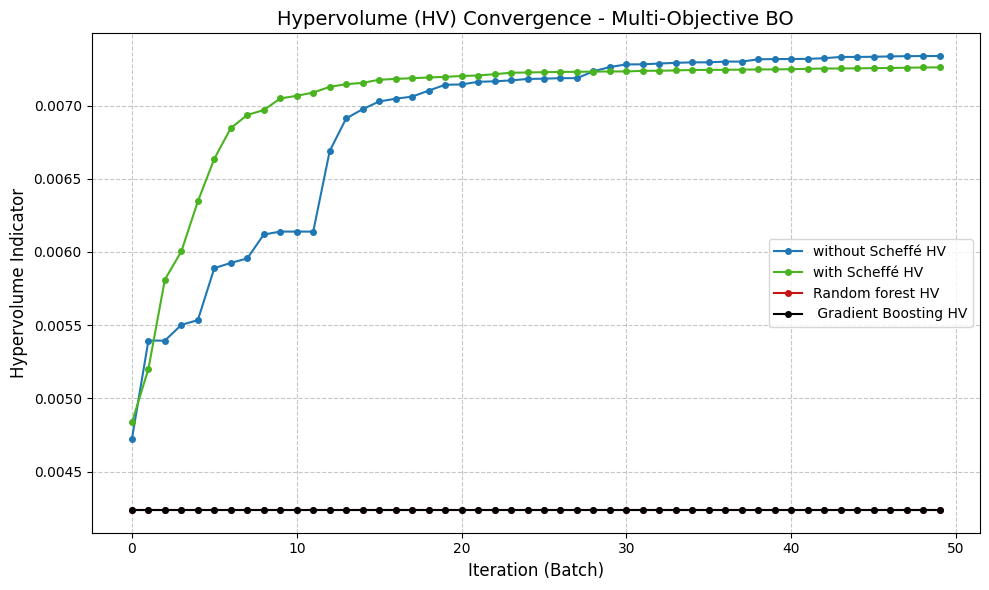

In [6]:
import json
import matplotlib.pyplot as plt

def plot_averages(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    if not data:
        return "JSON 文件中沒有數據。"
    
    hv_history = data.get('hv_history')

    return hv_history


def tree_averages(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    if not data:
        return "JSON 文件中沒有數據。"
    
    return data



base_gp_hv_history = plot_averages("D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_gp_result33/synthetic_data_sparse_seed_39.json")
Scheffé_gp_hv_history = plot_averages("D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result44/synthetic_data_sparse_seed_39.json")
rf_history = tree_averages("D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/tree_result/hv_history.json")
gb_history = tree_averages("D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/tree_result/hv_history.json")


# 3. 繪圖
plt.figure(figsize=(10, 6))
plt.plot(base_gp_hv_history, marker='o', linestyle='-', color='#1f77b4', markersize=4, label='without Scheffé HV')
plt.plot(Scheffé_gp_hv_history, marker='o', linestyle='-', color="#49b41f", markersize=4, label='with Scheffé HV')
plt.plot(rf_history, marker='o', linestyle='-', color="#c51515", markersize=4, label='Random forest HV')
plt.plot(gb_history, marker='o', linestyle='-', color="#000000", markersize=4, label=' Gradient Boosting HV')


# # 計算累積最大值 (Running Maximum) 以顯示收斂狀況
# running_max = [max(hv_history[:i+1]) for i in range(len(hv_history))]
# plt.step(range(len(running_max)), running_max, where='post', color='red', alpha=0.6, label='Best HV')

# 圖表格式設定
plt.title('Hypervolume (HV) Convergence - Multi-Objective BO', fontsize=14)
plt.xlabel('Iteration (Batch)', fontsize=12)
plt.ylabel('Hypervolume Indicator', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
import json

# 假設您的檔案名稱為 performance_report.json
def calculate_performance_averages(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    if not data:
        return "JSON 文件中沒有數據。"

    n = len(data)
    
    # 提取各項數值
    runtimes = [entry['runtime_sec'] for entry in data]
    cpu_mems = [entry['cpu_memory_mb'] for entry in data]
    gpu_mems = [entry.get('gpu_alloc_mb', 0) for entry in data] # 使用 get 以防某些紀錄沒用到 GPU

    # 計算平均
    avg_runtime = sum(runtimes) / n
    avg_cpu = sum(cpu_mems) / n
    avg_gpu = sum(gpu_mems) / n

    print(f"--- Scheffe mean 統計報告 (共 {n} 筆紀錄) ---")
    print(f"平均執行時間: {avg_runtime:.4f} sec")
    print(f"平均 CPU 使用量: {avg_cpu:.2f} MB")
    print(f"平均 GPU 佔用量: {avg_gpu:.2f} MB")

# 執行範例
calculate_performance_averages("D:/Users/TingYuLin/Desktop/py12/MOBO/Scheffe_gp/base_schyeffe_result44/final_performance_seed_39.json")

--- Scheffe mean 統計報告 (共 50 筆紀錄) ---
平均執行時間: 36.2350 sec
平均 CPU 使用量: 1251.34 MB
平均 GPU 佔用量: 23.01 MB
